### Deep Fool Algorithm 

We have achieved some results with the CNN and MLP models, but we would like to explore how these models perform when faced with adversarial examples. To do so, we aply DeepFool.

**DeepFool** is a widely used method for generating adversarial examples, designed to evaluate the robustness of machine learning models, particularly in classification tasks. 

By iteratively finding the minimal perturbation needed to alter a model's prediction, DeepFool provides insights into a **model's vulnerability to adversarial attacks**. This method is crucial for developing more **robust and reliable models**, as it helps identify potential weaknesses and informs strategies for improving their defense mechanisms

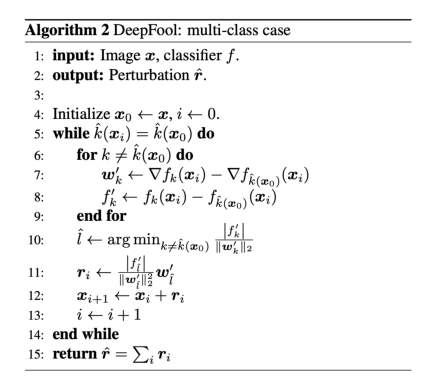

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('images/DeepFool_algorithm.png') 

# Exibir a imagem
plt.imshow(img)
plt.axis('off')
plt.show()



1. **Initialization:** Starting with the original image \( $x_0$ \), and setting the iteration counter \($ i $\) to 0.

2. **Perturbation Calculation:** For each iteration:
   - The algorithm calculates the perturbation required to change the model's prediction, iteratively adjusting the image.
   - It computes the gradients and the necessary perturbation \( $r_i $\) for the class boundary.

3. **Repeat Until Misclassification:** The algorithm repeats this process until the image is misclassified by the model.

4. **Return Perturbation:** The final perturbation is the sum of all the adjustments \( $r_i$ \) made during the iterations.

The result is the minimal perturbation $ r $ that causes a misclassification.


In [7]:
# import of relevant libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers
from tensorflow.python.client import device_lib
import pandas as pd
import numpy as np
import pickle
import os
import librosa
from copy import deepcopy

In [9]:
def get_gradient(model, x, target_class):
    """
    Calcula o gradiente da saída da classe-alvo com respeito à entrada.

    Args:
        model: O modelo neural treinado.
        x: Entrada para o modelo (tensor).
        target_class: Índice da classe-alvo.

    Returns:
        Gradiente calculado.
    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        target_logits = logits[:, target_class]
    return tape.gradient(target_logits, x)


In [10]:
import numpy as np

def deepfool(model, x0, eta=1e-2, max_iter=50, num_classes=10):
    """
    Implementa o algoritmo DeepFool para calcular a menor perturbação.

    Args:
        model: O modelo neural treinado.
        x0: Entrada inicial (tensor).
        eta: Parâmetro de overshoot.
        max_iter: Número máximo de iterações.
        num_classes: Número de classes no modelo.

    Returns:
        r_sum: Perturbação acumulada.
        loop_i: Número de iterações realizadas.
        label_xi: Nova previsão após a perturbação.
    """
    x = tf.convert_to_tensor(x0, dtype=tf.float32)
    r_sum = tf.zeros_like(x)
    label_xi = tf.argmax(model(x), axis=1).numpy()[0]

    for loop_i in range(max_iter):
        gradients = []
        logits = model(x)
        current_label = tf.argmax(logits, axis=1).numpy()[0]

        if current_label != label_xi:
            break

        for k in range(num_classes):
            grad = get_gradient(model, x, k)
            gradients.append(grad)

        gradients = tf.stack(gradients)
        logits = tf.squeeze(logits)

        smallest_perturbation = float('inf')
        for k in range(num_classes):
            if k == label_xi:
                continue
            w_k = gradients[k] - gradients[label_xi]
            f_k = logits[k] - logits[label_xi]
            perturbation = tf.abs(f_k) / tf.norm(w_k, ord=2)
            if perturbation < smallest_perturbation:
                smallest_perturbation = perturbation
                r_i = (perturbation + eta) * w_k / tf.norm(w_k, ord=2)

        r_sum += r_i
        x = x + r_i

    return r_sum, loop_i, current_label


In [11]:
def example_robustness(r, x):
    """
    Calcula a robustez de um exemplo.

    Args:
        r: Perturbação adversarial aplicada.
        x: Entrada original.

    Returns:
        Valor de robustez (ρ).
    """
    norm_r = tf.norm(r)
    norm_x = tf.norm(x)
    return norm_r / norm_x


In [12]:
def model_robustness(model, X_test, y_test):
    """
    Avalia a robustez média do modelo em relação ao conjunto de testes.

    Args:
        model: O modelo neural treinado.
        X_test: Conjunto de dados de teste.
        y_test: Labels do conjunto de teste.

    Returns:
        Média e desvio padrão da robustez.
    """
    rho_values = []
    for i in range(len(X_test)):
        x = tf.expand_dims(X_test[i], axis=0)
        r, _, _ = deepfool(model, x)
        rho = example_robustness(r, x)
        rho_values.append(rho.numpy())
    
    mean_rho = np.mean(rho_values)
    std_rho = np.std(rho_values)
    return mean_rho, std_rho


In [ ]:
class MLP(tf.keras.Model):
    def __init__(self, input_dim, output_dim, hidden_units, dropout_rate, activations, regularization_type=None, regularization_value=0.01):
        super(MLP, self).__init__()
        self.hidden_layers = []
        self.regularization_type = regularization_type
        self.regularization_value = regularization_value

        for units, activation in zip(hidden_units, activations):
            self.hidden_layers.append(
                tf.keras.layers.Dense(units, activation=activation)
            )
            self.hidden_layers.append(tf.keras.layers.Dropout(dropout_rate))
        
        self.output_layer = tf.keras.layers.Dense(output_dim, activation='softmax')  


    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)
    
    def compute_regularization_loss(self):
        regularization_loss = 0.0
        if self.regularization_type:
            for layer in self.hidden_layers:
                if isinstance(layer, tf.keras.layers.Dense):
                    weights = layer.kernel
                    if self.regularization_type == 'l1':
                        regularization_loss += tf.reduce_sum(tf.abs(weights)) * self.regularization_value
                    elif self.regularization_type == 'l2':
                        regularization_loss += tf.reduce_sum(tf.square(weights)) * self.regularization_value
        return regularization_loss

def load_fold_data(fold_index, files):
    data = np.genfromtxt(files[fold_index], delimiter=',')
    X = data[:, :-1]  # Features
    y = data[:, -1].astype(int)  # Labels
    return X, y

files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]

# Definir o conjunto de teste como o primeiro fold
fold_test = 1
X_test, y_test = load_fold_data(fold_test, files)

# Definir o conjunto de treino usando os outros folds
X_train, y_train = [], []
for i in range(1, 11):  # Total de 10 folds
    if i != fold_test:
        X_temp, y_temp = load_fold_data(i, files)
        X_train.append(X_temp)
        y_train.append(y_temp)

# Concatenar os dados de treino
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)


# Definir modelo com os melhores hiperparâmetros
best_config = {
    'hidden_units': [256, 128, 64],
    'activations': ['relu', 'relu', 'relu'],
    'dropout_rate': 0.3,
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 0.0001,
    'regularization_type': None,
    'regularization_value': 0.01
}

# Inicializar e treinar o modelo
model = MLP(
    input_dim=X_train.shape[1],
    output_dim=10,  # Classes de 0 a 9
    hidden_units=best_config['hidden_units'],
    dropout_rate=best_config['dropout_rate'],
    activations=best_config['activations']
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_config['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=best_config['batch_size'],
    epochs=best_config['epochs']
)




NameError: name 'MLP' is not defined

In [ ]:
# Avaliar robustez do modelo
mean_rho, std_rho = model_robustness(model, X_test, y_test)
print(f"Robustez média: {mean_rho:.4f}")
print(f"Desvio padrão da robustez: {std_rho:.4f}")
